In [2]:
# -*- coding: utf-8 -*-
from threading import Thread
import time
from tkinter import *
from tkinter import ttk, messagebox
from tkinter.scrolledtext import ScrolledText
from dobot_api import *
import json
from files.alarm_controller import alarm_controller_list
from files.alarm_servo import alarm_servo_list

In [3]:
# 라이브러리 불러오기
import threading
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

from time import sleep

from pose_ArUCo.pose_estimation import run_aruco
from pose_ArUCo.detect_aruco_images import detect_marker
from dobot_api import DobotApiDashboard, DobotApi, DobotApiMove, MyType
from rotate import transform_cam_to_robot

In [4]:
import ham_api
ham_robotui = ham_api.RobotUI()

In [10]:
# Enable

ham_robotui.connect_port()
ham_robotui.client_dash.ClearError()
ham_robotui.enable()

연결 성공
self.global_state(connect) True
robot_mode: 4
test_value: 0x123456789abcdef


Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\hamjo\anaconda3\envs\dobot39\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\hamjo\anaconda3\envs\dobot39\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hamjo\Documents\PW\Hyundai\ham_Dobot\ham_Dobot\example_code\ham_api.py", line 451, in feed_back
    self.label_feed_speed["text"] = a["speed_scaling"][0]
  File "C:\Users\hamjo\anaconda3\envs\dobot39\lib\tkinter\__init__.py", line 1657, in __setitem__
    self.configure({key: value})
  File "C:\Users\hamjo\anaconda3\envs\dobot39\lib\tkinter\__init__.py", line 1646, in configure
    return self._configure('configure', cnf, kw)
  File "C:\Users\hamjo\anaconda3\envs\dobot39\lib\tkinter\__init__.py", line 1636, in _configure
    self.tk.call(_flatten((self._w, cmd)) + self._options(cnf))
RuntimeError: main thread is not in main loop


In [11]:
for i in range(5):
    ham_robotui.ham_move_coord2()
    ham_robotui.ham_move_coord()

In [ ]:
# gripper ON
ham_robotui.client_dash.ToolDO(1, 1)

'0,{},ToolDO(1,1);'

In [7]:
# gripper OFF
ham_robotui.client_dash.ToolDO(1, 0)

'0,{},ToolDO(1,0);'

In [12]:
def move_grip_test(self, point_list):
    self.client_move.MovJ(point_list[0], point_list[1], point_list[2], point_list[3], point_list[4], point_list[5])

In [13]:
h_1 = -55.0
h_2 = -38.0

In [5]:
def ham_aruco(edit_x = -35.4, edit_y = -25.9, edit_z = -130.4, edit_yaw = 0):
    # 웹캠 이미지 받아오기
    cap = cv2.VideoCapture(2)
    ret, img = cap.read()

    # 웹캠 이미지를 RGB로 변환
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 웹캠 이미지 보기
#     plt.imshow(img_rgb)
#     plt.show()

    cap.release()
    
    # 마커 검출
    detected_markers = detect_marker(image=img_rgb, marker_type="DICT_4X4_100")

    # 마커 검출 이미지 보기
    plt.imshow(detected_markers)
    plt.show()
    
    # 아르코 마커로 카메라 좌표계 기준 6D pose 예측하기
    # rvec : 회전 행렬 (roll, pitch, yaw)   // unit : rads
    # tvec : 이동 행렬 (x, y, z)            // unit : meter
    # corners : 아르코 마커의 각 코너 좌표  // (x, y) 픽셀 위치
    rvec, tvec, corners = run_aruco(img)

    # 간단한 전처리
    rvec = np.array(rvec).flatten() 
    tvec = np.array(tvec).flatten()
    corners = np.array(corners[0][0])

    # 회전 행렬, 이동 행렬, 마커 코너 좌표 출력
    print(f"rotate vector : {rvec} rads")
    print(f"translation vector : {tvec} meters \n")
    print(f"marker corners : {corners}")
    
    # 오차 보정을 통한 좌표 및 각도 보정
    tvec[0] = round(tvec[0], 4)
    tvec[1] = round(tvec[1], 4)
    tvec[2] = round(tvec[2], 4)
    yaw_angle_by_cam = round(rvec[-1], 4)
    print('rvec : ', rvec)

    print(f"x based camera cordinate: {tvec[0]} meter")
    print(f"y based camera cordinate: {tvec[1]} meter")
    print(f"z based camera cordinate: {tvec[2]} meter")
    print(f"yaw_angle_by_cam : {yaw_angle_by_cam} rads")

#     # 카메라 좌표계 -> 로봇 베이스 좌표계로 변환
    point_grip = transform_cam_to_robot(tvec)
#     print(f"before : {point_grip}")
#     point_grip[0] = round(point_grip[0] + edit_x, 4)
#     point_grip[1] = round(point_grip[1] + edit_y, 4)
#     point_grip[2] = round(point_grip[2] + edit_z, 4)
    yaw_angle_by_robot = round((math.degrees(-yaw_angle_by_cam) + edit_yaw), 4)

    # yaw 변환 각도 값 추가
    point_grip = np.append(point_grip, yaw_angle_by_robot)
    point_grip = np.append(point_grip, 0)
    point_grip = np.append(point_grip, 0)
    print(f"x pose by robot : {point_grip[0]} mm")
    print(f"y pose by robot : {point_grip[1]} mm")
    print(f"z pose by robot : {point_grip[2]} mm")
    print(f"yaw angle by robot : {point_grip[3]} degree")
    
    print(f"after : {point_grip}")

    
    return point_grip

In [15]:
def ham_ArucoFixedPoint(point_grip, rate = 1.5):
    Ximg_origin, Yimg_origin = 333, 23
    X_origin, Y_origin = 286, 1.5
    point_grip[0] = X_origin + (point_grip[0] - Ximg_origin)*rate
    point_grip[1] = Y_origin + (point_grip[1] - Yimg_origin)*rate
    
    return point_grip

In [16]:
h = h_1

ham_robotui.move_ready()
point_grip = ham_aruco()
ham_ArucoFixedPoint(point_grip)

move_grip_test(ham_robotui, point_grip)
point_grip[2] = h
move_grip_test(ham_robotui, point_grip)
# ham_robotui.client_dash.GetPose()
ham_robotui.client_dash.ToolDO(1, 1)
ham_robotui.move_ready()
ham_robotui.client_dash.ToolDO(1, 0)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [17]:
# Disable
ham_robotui.enable()
ham_robotui.client_dash.ClearError()
ham_robotui.connect_port()

연결 해제 성공


In [8]:
# Recovery
ham_robotui.enable()
ham_robotui.client_dash.ClearError()
ham_robotui.enable()

AttributeError: 'NoneType' object has no attribute 'DisableRobot'

In [5]:
ham_robotui.client_dash.SpeedFactor(25)

'0,{},SpeedFactor(25);'

In [6]:
ham_robotui.client_dash.GetPose()

'0,{332.757816,2.607984,46.071465,204.119095,0.000000,0.000000},GetPose();'

In [7]:
ham_robotui.client_move.JointMovJ(136.864,
            59.315,
            76.295,
            128.524)

'0,{},JointMovJ(136.864000,59.315000,76.295000,128.524000);'

In [5]:
ham_robotui.move_ready()

'0,{},MovJ(129.796103,225.926990,-5.210310,73.154968,0.000000,0.000000);'

In [14]:
ham_robotui.client_dash.ToolDO(1, 1)

'0,{},ToolDO(1,1);'

In [9]:
ham_robotui.client_dash.ToolDO(1, 0)

'0,{},ToolDO(1,0);'

In [7]:
for i in range(5):
    ham_robotui.ham_move_coord2()
    ham_robotui.ham_move_coord()

In [11]:
def move_grip_test(self, point_list):
    self.client_move.MovJ(point_list[0], point_list[1], point_list[2], point_list[3], point_list[4], point_list[5])

In [12]:
h_1 = -55.0
h_2 = -38.0

In [1]:
def ham_aruco(edit_x = -35.4, edit_y = -25.9, edit_z = -130.4, edit_yaw = 0):
    # 웹캠 이미지 받아오기
    cap = cv2.VideoCapture(-1)
    ret, img = cap.read()

    # 웹캠 이미지를 RGB로 변환
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 웹캠 이미지 보기
#     plt.imshow(img_rgb)
#     plt.show()

    cap.release()
    
    # 마커 검출
    detected_markers = detect_marker(image=img_rgb, marker_type="DICT_4X4_100")

    # 마커 검출 이미지 보기
    plt.imshow(detected_markers)
    plt.show()
    
    # 아르코 마커로 카메라 좌표계 기준 6D pose 예측하기
    # rvec : 회전 행렬 (roll, pitch, yaw)   // unit : rads
    # tvec : 이동 행렬 (x, y, z)            // unit : meter
    # corners : 아르코 마커의 각 코너 좌표  // (x, y) 픽셀 위치
    rvec, tvec, corners = run_aruco(img)

    # 간단한 전처리
    rvec = np.array(rvec).flatten() 
    tvec = np.array(tvec).flatten()
    corners = np.array(corners[0][0])

    # 회전 행렬, 이동 행렬, 마커 코너 좌표 출력
    print(f"rotate vector : {rvec} rads")
    print(f"translation vector : {tvec} meters \n")
    print(f"marker corners : {corners}")
    
    # 오차 보정을 통한 좌표 및 각도 보정
    tvec[0] = round(tvec[0], 4)
    tvec[1] = round(tvec[1], 4)
    tvec[2] = round(tvec[2], 4)
    yaw_angle_by_cam = round(rvec[-1], 4)
    print('rvec : ', rvec)

    print(f"x based camera cordinate: {tvec[0]} meter")
    print(f"y based camera cordinate: {tvec[1]} meter")
    print(f"z based camera cordinate: {tvec[2]} meter")
    print(f"yaw_angle_by_cam : {yaw_angle_by_cam} rads")

#     # 카메라 좌표계 -> 로봇 베이스 좌표계로 변환
    point_grip = transform_cam_to_robot(tvec)
#     print(f"before : {point_grip}")
#     point_grip[0] = round(point_grip[0] + edit_x, 4)
#     point_grip[1] = round(point_grip[1] + edit_y, 4)
#     point_grip[2] = round(point_grip[2] + edit_z, 4)
    yaw_angle_by_robot = round((math.degrees(-yaw_angle_by_cam) + edit_yaw), 4)

    # yaw 변환 각도 값 추가
    point_grip = np.append(point_grip, yaw_angle_by_robot)
    point_grip = np.append(point_grip, 0)
    point_grip = np.append(point_grip, 0)
    print(f"x pose by robot : {point_grip[0]} mm")
    print(f"y pose by robot : {point_grip[1]} mm")
    print(f"z pose by robot : {point_grip[2]} mm")
    print(f"yaw angle by robot : {point_grip[3]} degree")
    
    print(f"after : {point_grip}")

    
    return point_grip

In [11]:
def ham_ArucoFixedPoint(point_grip, rate = 1.5):
    Ximg_origin, Yimg_origin = 333, 23
    X_origin, Y_origin = 286, 1.5
    point_grip[0] = X_origin + (point_grip[0] - Ximg_origin)*rate
    point_grip[1] = Y_origin + (point_grip[1] - Yimg_origin)*rate
    
    return point_grip

Detecting 'DICT_4X4_100' tags....


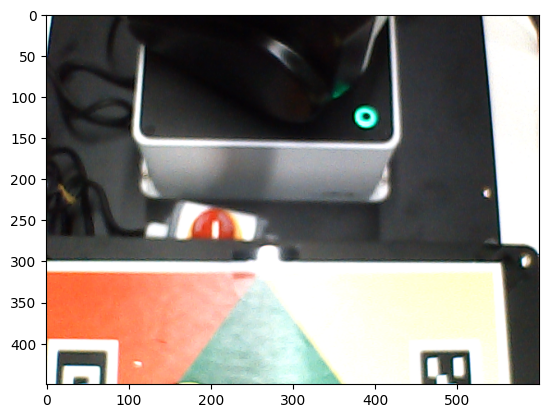

IndexError: tuple index out of range

In [12]:
h = h_1

ham_robotui.move_ready()
point_grip = ham_aruco()
ham_ArucoFixedPoint(point_grip)

move_grip_test(ham_robotui, point_grip)
point_grip[2] = h
move_grip_test(ham_robotui, point_grip)
# ham_robotui.client_dash.GetPose()
ham_robotui.client_dash.ToolDO(1, 1)
ham_robotui.move_ready()
ham_robotui.client_dash.ToolDO(1, 0)

Detecting 'DICT_4X4_100' tags....
[Inference] ArUco marker ID: 4


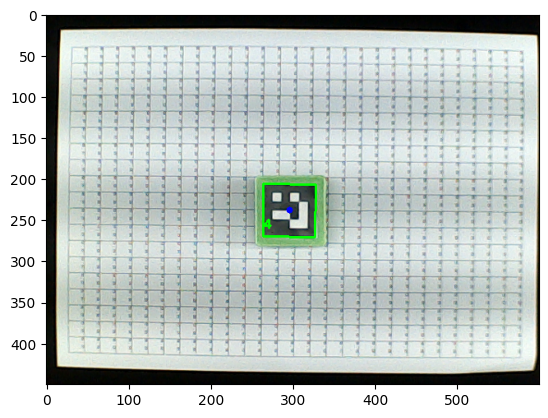

rotate vector : [ 2.23669151 -2.20389869 -0.01884157] rads
translation vector : [ 0.0082561  -0.01041769  0.30211776] meters 

marker corners : [[281. 288.]
 [282. 220.]
 [350. 221.]
 [349. 289.]]
rvec :  [ 2.23669151 -2.20389869 -0.01884157]
x based camera cordinate: 0.0083 meter
y based camera cordinate: -0.0104 meter
z based camera cordinate: 0.3021 meter
yaw_angle_by_cam : -0.0188 rads
x pose by robot : 339.99999999999994 mm
y pose by robot : 23.0 mm
z pose by robot : 88.00000000000003 mm
yaw angle by robot : 1.0772 degree
after : [340.      23.      88.       1.0772   0.       0.    ]


In [125]:
h = h_2

ham_robotui.move_ready()
point_grip = ham_aruco()
ham_ArucoFixedPoint(point_grip)

move_grip_test(ham_robotui, point_grip)
point_grip[2] = h
move_grip_test(ham_robotui, point_grip)
# ham_robotui.client_dash.GetPose()

In [ ]:
h = h_2

ham_robotui.move_ready()
point_grip = ham_aruco()
ham_ArucoFixedPoint(point_grip)

move_grip_test(ham_robotui, point_grip)
point_grip[2] = h
move_grip_test(ham_robotui, point_grip)
# ham_robotui.client_dash.GetPose()

In [ ]:
ham_robotui.client_move.MovJ(286,
            1.5,
            76.295,
            128.524)

In [6]:
import DobotYOLOv3.yolov3.DobotYOLO as hy

In [7]:
hy.get_results()

NameError: name 'DobotDetect' is not defined